In [2]:
import pandas as pd
import re
import nltk
from nltk.tokenize import sent_tokenize
import spacy
import networkx as nx
import matplotlib.pyplot as plt
from operator import add
from scripts.detail_extractor import actionTaken, getViolations, getViolators, getAllPenalties, getDate, getViolations2, getViolations3

In [3]:
import en_core_web_lg
nlp = en_core_web_lg.load()

In [18]:
def identify_crime(text, types, folders):
    text = text.lower()
    data = []
    count = [0, 0, 0, 0]
    for i in range(len(types)):
        if(text.find(types[i]) != -1):
            data.append(folders[i])
            count[i] = 1
    return data, count

In [19]:
def create_graph(final_nodes):
    source = []
    target = []
    edge = []
    indexes = []

    for i in (range(len(final_nodes))):
        ent1 = final_nodes[i][0]
        ent2 = final_nodes[i][2]
        rel = final_nodes[i][1] 
        source.append(ent1.lower().strip())
        target.append(ent2.lower().strip())
        edge.append("".join(rel).strip())
        indexes.append(i)
    if(len(edge) == 0 or len(final_nodes) == 0):
        return None
    else:
        G = nx.DiGraph(directed=True)
        for i in (range(len(edge))):
            G.add_weighted_edges_from([(source[i], target[i], i)])
        size=20
        if len(edge)/2 > 20:
            size = len(edge)/2
        plt.figure(figsize = (size, size))
        edge_labels = dict([((u, v, ), edge[d['weight']]) for u, v, d in G.edges(data = True)])
        pos = nx.spring_layout(G, k = 0.8)
        nx.draw(G, with_labels = True, node_color = 'lightblue', node_size=5000, edge_color='r', edge_cmap = plt.cm.Blues, pos=pos, font_size=20)
        nx.draw_networkx_edge_labels(G, pos, edge_labels = edge_labels, font_size = 15)
        return G, edge_labels

In [20]:
df = pd.read_csv('./results/data_small.csv')

df.Text = df.Text.apply(lambda x : x.replace('\\n', '\n'))
df.Text = df.Text.apply(lambda x : x.replace('\\t', '\t'))

types = ['insider', 'misappropriate', 'unregister', 'fraud']
folders = ['Insider Trading', 'Misappropriated Funds', 'Unregistered', 'Fraud']
count = [0, 0, 0, 0]
crimes = []
actions = []
violations = []
violators = []
fines = []
dates = []
years = []

yrs = set()
counts = {}

for i in range(len(df['Text'])-30):
    text = df['Text'][i]
    crimes.append(identify_crime(text, types, folders)[0])
    action = actionTaken(text)
    violation = getViolations(text)
    violator = getViolators(text)
    fine = getAllPenalties(text)
    date, year = getDate(text)
    
    violations.append(violation)
    violators.append(violator)
    actions.append(action)
    fines.append(fine)
    dates.append(date)
    years.append(year)
    
    if(year != ''):
        yrs.add(year)
        
y = sorted(yrs)
        
for i in range(len(y)):
    counts[y[i]] = count
    
total = [0, 0, 0, 0]
    
for i in range(len(df['Text'])-30):
    text = df['Text'][i]
    _, count = identify_crime(text, types, folders)
    _, year = getDate(text)
    if(year != ''):
        counts[year] = list(map(add, counts[year], count))

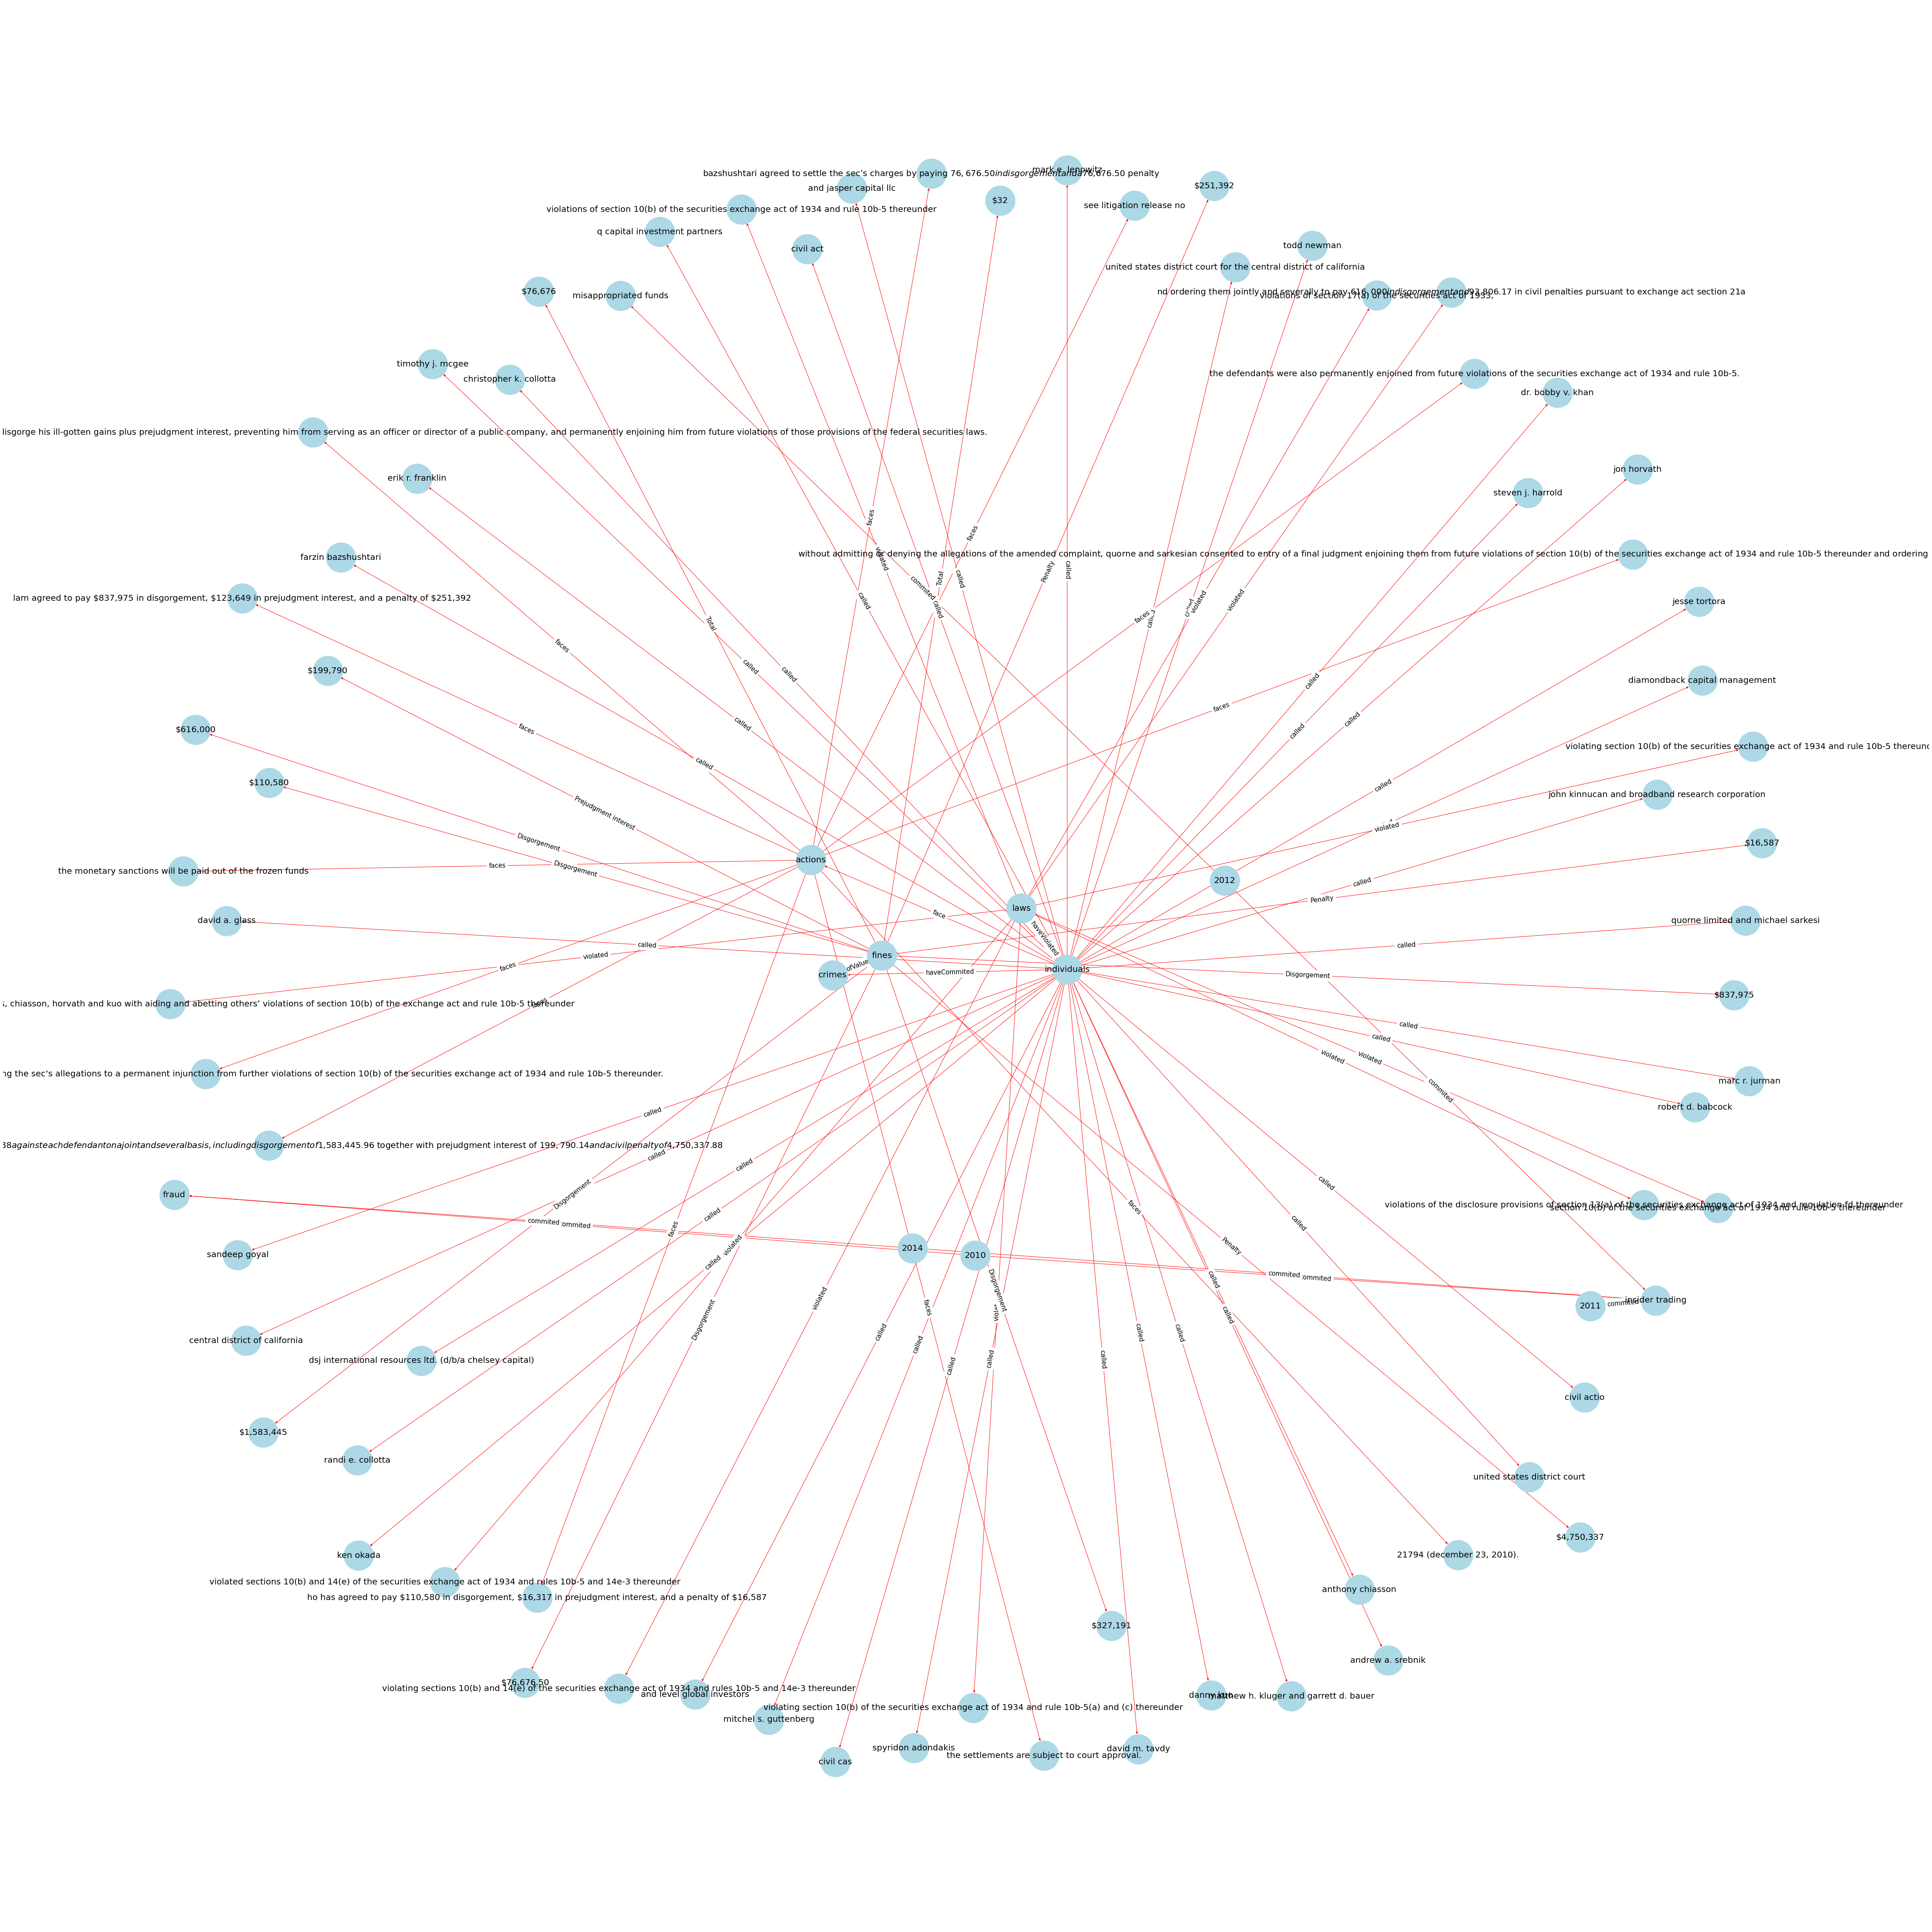

In [21]:
nodes = []

for i in range(len(crimes)):
    nodes.append(('individuals', 'haveCommited', 'crimes'))
    nodes.append(('individuals', 'haveViolated', 'laws'))
    nodes.append(('crimes', 'ofValue', 'fines'))
    nodes.append(('individuals', 'face', 'actions'))
    for violator in violators[i]:
        nodes.append(('individuals', 'called', violator))
    for crime in crimes[i]:
        nodes.append(('crimes', 'commited', crime))
    for violation in violations[i]:
        nodes.append(('laws', 'violated', violation))
    for action in actions[i]:
        nodes.append(('actions', 'faces', action))
    for fine in fines[i]:
        nodes.append(('fines', fine[0], fine[1]))

create_graph(nodes)
plt.savefig('./results/images/nested.png')